In [1]:
## Import library gb_mep
import gb_mep

In [2]:
## Load all required files after importing relevant libraries
import pickle
import numpy as np
import pandas as pd
santander_train = pd.read_csv('../data/santander_train.csv') 
santander_test = pd.read_csv('../data/santander_test.csv') 
santander_distances = np.load('../data/santander_distances.npy')
with open('../data/santander_dictionary.pkl', 'rb') as f:
    santander_dictionary = pickle.load(f)


In [3]:
santander_train

,start_id,end_id,start_time,end_time
0,722,131,0.483492,13.192747
1,531,460,0.484768,23.477447
2,515,603,0.624303,4.196019
3,804,689,0.807900,13.604670
4,740,48,1.568787,31.912915
...,...,...,...,...
6453258,302,637,241912.321072,241919.498489
6453259,740,342,241912.686823,241919.489431
6453260,327,324,241913.941339,241917.596443
6453261,224,337,241913.962367,241919.498538


In [4]:
G = gb_mep.gb_mep(df=santander_train, id_map=santander_dictionary, distance_matrix=santander_distances)
self = G


In [16]:
from scipy.optimize import minimize
x0 = -5*np.ones(1)
subset_nodes=list(range(5)); start_times=False; end_times=False; distance_start=True; distance_end=False; thresh=1
# Define the dictionary for results
res = {}
# If the subset of nodes is not specified, consider all nodes
if subset_nodes is None:
    subset_nodes = self.nodes
# Loop over all nodes in the subset
for node in subset_nodes:
    # Print node and name
    print('\r', node, '-', self.id_map[node], ' '*20, end='\r')
    # Obtain distances if required
    if distance_start or distance_end:
        ds = self.distance_matrix[node]
    # Calculate required elements for recursion
    time_diffs_A = {}; time_diffs_A_prime = {}
    if not start_times and not end_times:
        condition_full = False
    else:
        condition_full = True
        condition = not (distance_start or distance_end)
    if condition_full:
        for secondary_node in ([node] if condition else np.where(ds < thresh)[0]):
            if self.N[secondary_node] + self.N_prime[secondary_node] > 0:
                start_breaks = np.searchsorted(a=self.start_times[secondary_node], v=self.start_times[node], side='left')
                end_breaks = np.searchsorted(a=self.end_times[secondary_node], v=self.start_times[node], side='left')
                for k, t in enumerate(self.start_times[node]):
                    if k != 0:
                        time_diffs_A[k, secondary_node] = t - self.start_times[secondary_node][start_breaks[k-1]:start_breaks[k]]
                        time_diffs_A_prime[k, secondary_node] = t - self.end_times[secondary_node][end_breaks[k-1]:end_breaks[k]]
                    else:
                        time_diffs_A[k, secondary_node] = t - self.start_times[secondary_node][:start_breaks[k]]
                        time_diffs_A_prime[k, secondary_node] = t - self.end_times[secondary_node][:end_breaks[k]]
            else:
                for k, t in enumerate(self.start_times[node]):
                    time_diffs_A[k, secondary_node] = np.array([])
                    time_diffs_A_prime[k, secondary_node] = np.array([])
    # Obtain the correct log-likelihood function based on fitting parameters
    if start_times and end_times and distance_start and distance_end:
        f = self.negative_loglikelihood_full
        f_args = (node, time_diffs_A, time_diffs_A_prime, np.where(ds < thresh)[0])
    elif start_times and end_times and distance_start and not distance_end:
        f = self.negative_loglikelihood_full_start
        f_args = (node, time_diffs_A, time_diffs_A_prime, np.where(ds < thresh)[0])
    elif start_times and end_times and not distance_start and not distance_end:
        f = self.negative_loglikelihood_smep
        f_args = (node, time_diffs_A, time_diffs_A_prime)
    elif start_times and not end_times:
        f = self.negative_loglikelihood_sep
        f_args = (node, time_diffs_A)
    elif not start_times and end_times:
        f = self.negative_loglikelihood_mep
        f_args = (node, time_diffs_A_prime)
    elif not start_times and not end_times:
        f = 'Poisson'
    # Minimise negative log-likelihood, or obtain exact solution if the function is simply the Poisson process
    if f == 'Poisson':
        res[node] = len(self.start_times[node]) / self.T
    else:
        res[node] = minimize(fun=f, x0=x0, args=f_args, method='L-BFGS-B')

In [21]:
pp = np.exp(res[4])
q = G.pvals_poisson_process(param=pp, node_index=4)

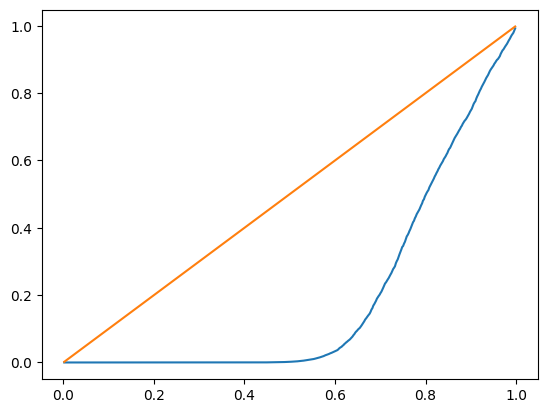

In [27]:
x = np.linspace(start=0, stop=1, num=501, endpoint=False)[1:]
y = np.percentile(a=q, q=x*100)
import matplotlib.pyplot as plt
plt.plot(x,y)
plt.plot(x,x)

In [15]:
np.min(q)

0.9997456729360318